In [47]:
import notebook_env
import importlib
importlib.reload(notebook_env)
from notebook_env import *

In [2]:
importlib.reload(refine_train)
importlib.reload(ode_models)
importlib.reload(odenet_cifar10)
importlib.reload(datasets)

<module 'odenet.datasets' from '/home/ubuntu/afq_odenet/ODENet/odenet/datasets.py'>

# Refinement with Euler and RK4

In [2]:
legend_name = lambda fname : re.search(r"ARCH(.*)", fname)[1]

In [70]:
dirs = glob('results/*CIFAR*-*Backprop*')
dirs = sorted(dirs, key = lambda x : os.stat(x).st_mtime)[:]
results = { name: torch.load(name) for name in dirs }
dirs

/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'odenet.ode_models.BatchNorm2DODE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet

In [72]:
df = pd.DataFrame(columns=["scheme", "variant", "time_d","refine epochs","final_time_d","depth","nsteps","accuracy","final time/epoch (S)", "total time (m)"])
for name, result in results.items():
    args = PostPack(name)
    if len(result.test_acc) < 159:
        acc = "NaN"
    else:
        acc = max(list(zip(*result.test_acc))[1])
    if not args.use_skip_init:
        var = "BatchNorm"
    else:
        var = "SkipInit"
    df.loc[len(df)] = \
        [args.scheme, var, args.initial_time_d, args.refine, args.final_time_d, args.final_time_d*2*3 + 1 + 2 + 2 + 1,
                    args.n_steps_per, acc, result.epoch_times[-1], sum(result.epoch_times)/60.0]
df.sort_values('accuracy')


,scheme,variant,time_d,refine epochs,final_time_d,depth,nsteps,accuracy,final time/epoch (S),total time (m)
34,euler,SkipInit,12,[],12,78,1,0.9054,46.681769,133.127765
0,euler,BatchNorm,1,[],1,12,1,0.9060,9.820485,26.063286
37,euler,SkipInit,2,[],2,18,1,0.9083,11.253361,30.648844
1,rk4_classic,BatchNorm,1,[],1,12,1,0.9091,14.865958,43.555413
36,rk4_classic,SkipInit,12,[],12,78,1,0.9091,132.893103,357.856191
41,euler,SkipInit,2,"[90, 130]",8,54,1,0.9109,26.158741,39.108096
33,rk4_classic,SkipInit,6,[],6,42,1,0.9117,57.158879,181.809700
44,rk4_classic,SkipInit,2,"[90, 130]",8,54,1,0.9127,72.795490,111.393333
39,euler,SkipInit,2,"[40, 60]",8,54,1,0.9134,25.283692,55.439916
30,euler,SkipInit,6,[],6,42,1,0.9136,27.161397,77.122023


In [58]:
_=df.loc[df.variant=='BatchNorm'].sort_values('accuracy')[["scheme","time_d","refine epochs","final_time_d","depth","accuracy","total time (m)"]]
_

,scheme,time_d,refine epochs,final_time_d,depth,accuracy,total time (m)
0,euler,1,[],1,12,0.9060,26.063286
1,rk4_classic,1,[],1,12,0.9091,43.555413
2,euler,2,[],2,18,0.9173,37.296441
4,rk4_classic,2,[],2,18,0.9187,68.630306
6,rk4_classic,3,[],3,24,0.9232,98.669537
15,euler,2,"[50, 100]",8,54,0.9254,48.078189
3,euler,3,[],3,24,0.9263,45.030018
10,euler,1,"[30, 45, 60]",8,54,0.9266,55.714782
24,rk4_classic,2,"[60, 120]",8,54,0.9272,177.474040
25,rk4_classic,2,"[50, 100]",8,54,0.9274,191.232651


In [59]:
print(_.to_latex(index=False))

\begin{tabular}{lllllrr}
\toprule
      scheme & time\_d &         refine epochs & final\_time\_d & depth &  accuracy &  total time (m) \\
\midrule
       euler &      1 &                    [] &            1 &    12 &    0.9060 &       26.063286 \\
 rk4\_classic &      1 &                    [] &            1 &    12 &    0.9091 &       43.555413 \\
       euler &      2 &                    [] &            2 &    18 &    0.9173 &       37.296441 \\
 rk4\_classic &      2 &                    [] &            2 &    18 &    0.9187 &       68.630306 \\
 rk4\_classic &      3 &                    [] &            3 &    24 &    0.9232 &       98.669537 \\
       euler &      2 &             [50, 100] &            8 &    54 &    0.9254 &       48.078189 \\
       euler &      3 &                    [] &            3 &    24 &    0.9263 &       45.030018 \\
       euler &      1 &          [30, 45, 60] &            8 &    54 &    0.9266 &       55.714782 \\
 rk4\_classic &      2 &         

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9168


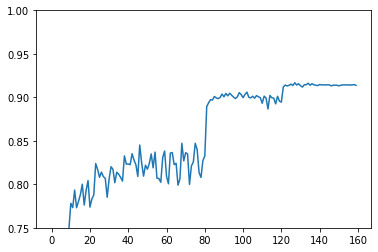

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9136


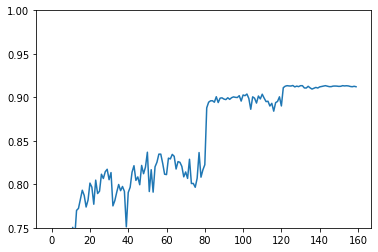

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9183


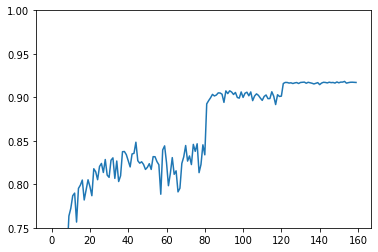

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9138


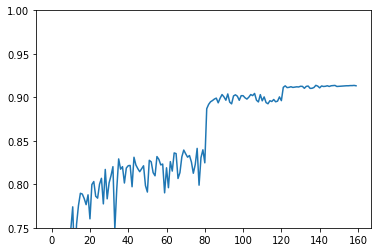

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9117


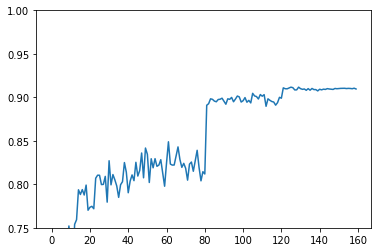

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-12-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9054


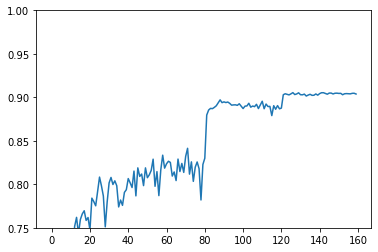

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9144


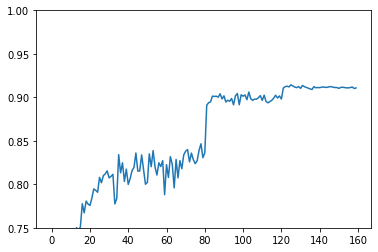

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-12-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9091


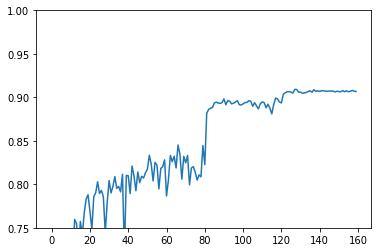

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9083


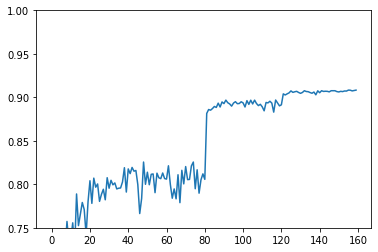

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9144


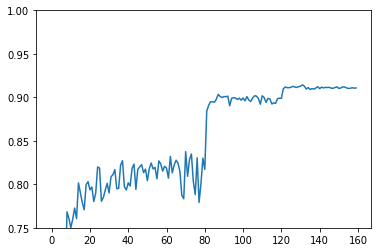

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[40, 60]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9134


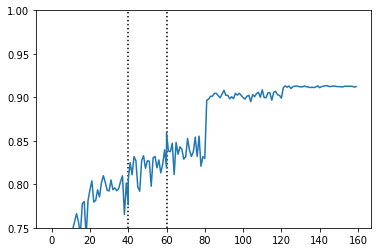

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9162


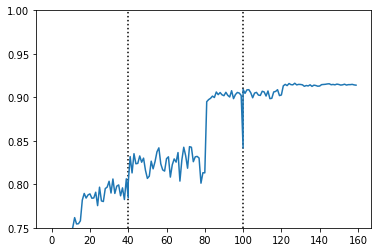

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9109


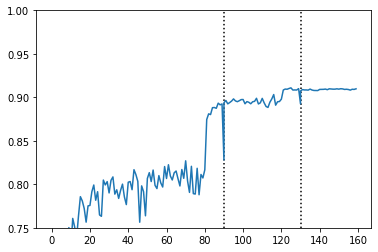

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 60]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9194


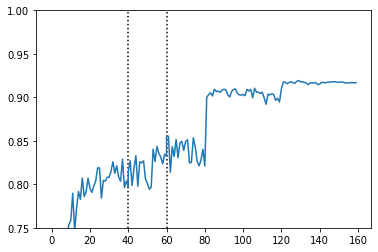

In [61]:
for name, result in results.items():
    #plt.plot(result.train_acc, label=legend_name(name))
    args = PostPack(name)
    if not args.use_skip_init: continue
    x,y = zip(*result.test_acc)
    plt.figure()
    plt.plot(x,y, '-', label=legend_name(name))
    try:
        x,y = zip(*result.train_acc)
        plt.plot(x,y, '--', label=legend_name(name))
    except: pass
    print((name),
          max(list(zip(*result.test_acc))[1]),)
          #max(list(zip(*result.train_acc))[1]))
    plt.vlines(args.refine,0,1, linestyle='dotted')
    plt.ylim(0.75,1)
    plt.show()
    plt.close('all')
    # plt.legend(loc=(0,-0.8))

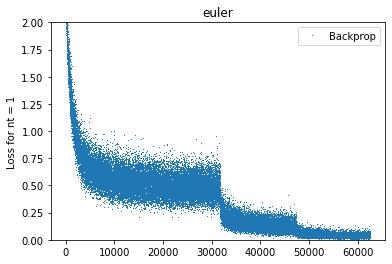

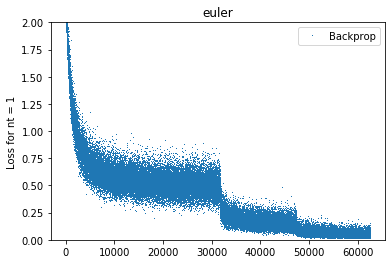

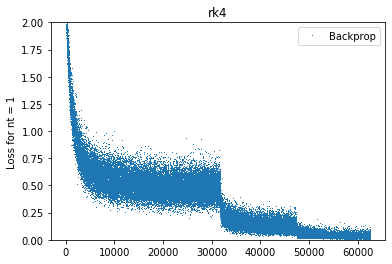

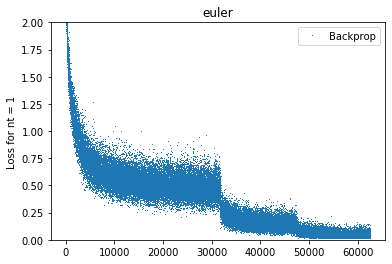

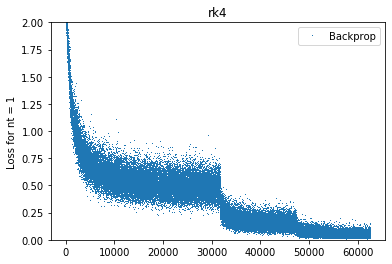

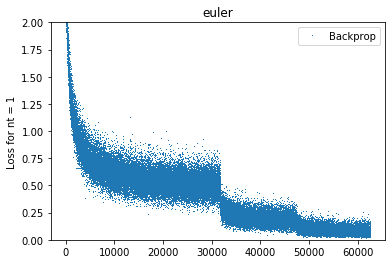

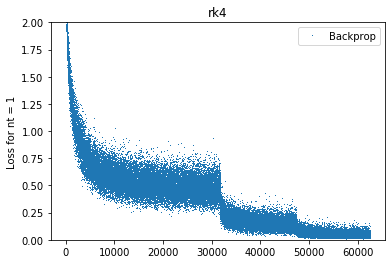

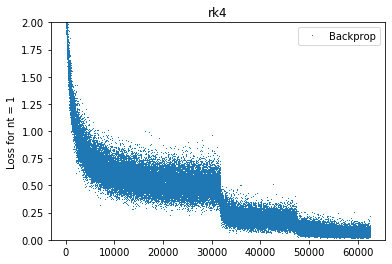

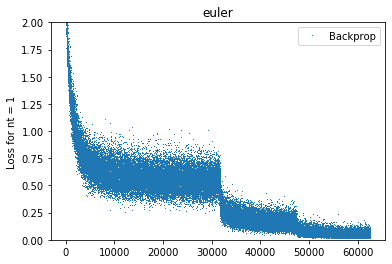

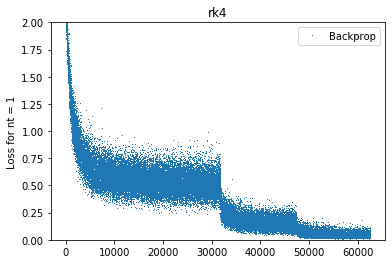

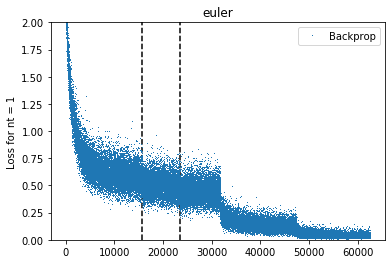

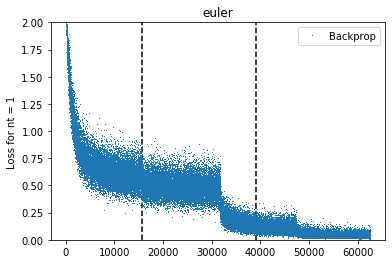

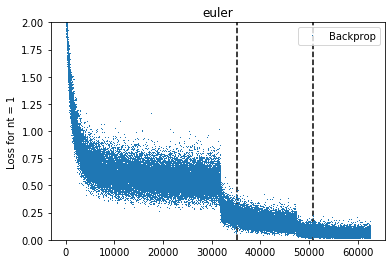

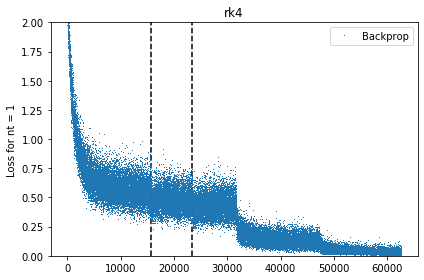

In [62]:
# plt.figure(figsize=(8,8))
for i,(name, result) in enumerate(results.items()):
    if "euler" in name:
        horiz = 0
    else:
        horiz = 1
    args = PostPack(name)
    if not args.use_skip_init: continue
    vert = 0
    # plt.subplot(3,2,1+horiz+2*vert)
    plt.figure()
    if horiz==0 and vert==0:
        plt.title("euler")
    if horiz==1 and vert==0:
        plt.title("rk4")
    if vert==2:
        plt.xlabel("step number")
    plt.ylabel(f"Loss for nt = { vert+1}")
    plt.plot(result.losses,
             '-' if "Adjoint" in name else ',',
             label="Adjoint" if "Adjoint" in name else "Backprop")
    plt.vlines(result.refine_steps, 0,2, linestyle='dashed')
    plt.legend()
    plt.ylim(0.,2)
plt.tight_layout()


# Plot their weights

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30]-0.1-Backprop-NormalInit-SEED-1.pkl


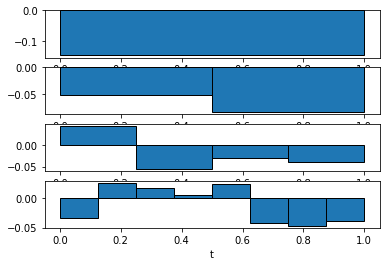

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[20, 30, 40]-0.1-Backprop-NormalInit-SEED-1.pkl


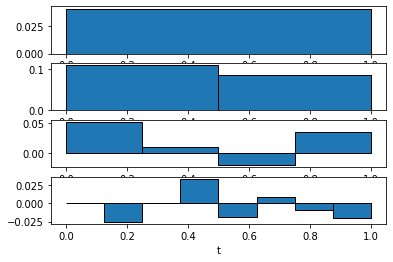

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[30, 45, 60]-0.1-Backprop-NormalInit-SEED-1.pkl


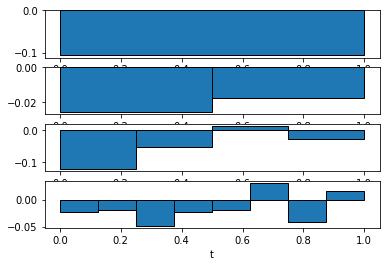

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30]-0.1-Backprop-NormalInit-SEED-1.pkl


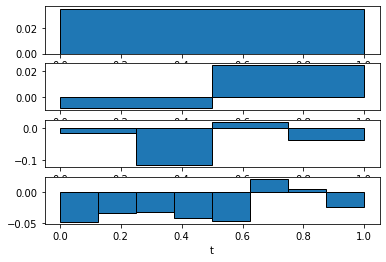

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-[30, 40]-0.1-Backprop-NormalInit-SEED-1.pkl


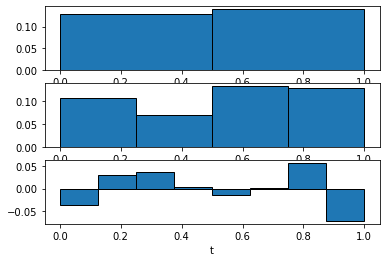

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-[45, 60]-0.1-Backprop-NormalInit-SEED-1.pkl


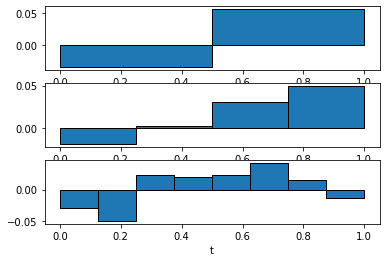

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-[60, 120]-0.1-Backprop-NormalInit-SEED-1.pkl


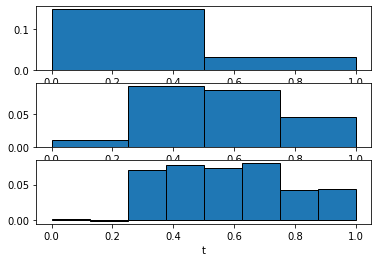

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-[50, 100]-0.1-Backprop-NormalInit-SEED-1.pkl


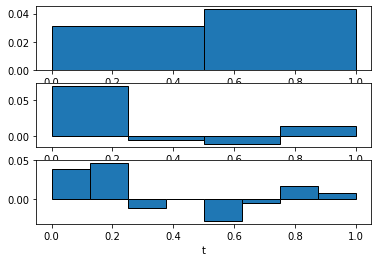

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 30, 40]-0.1-Backprop-NormalInit-SEED-1.pkl


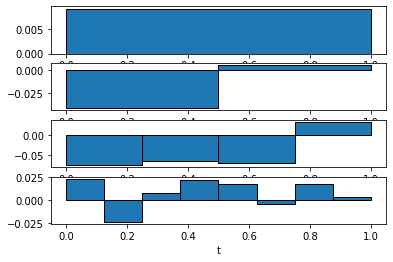

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-[40, 80]-0.1-Backprop-NormalInit-SEED-1.pkl


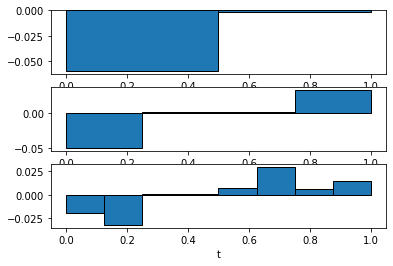

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-[30, 60]-0.1-Backprop-NormalInit-SEED-1.pkl


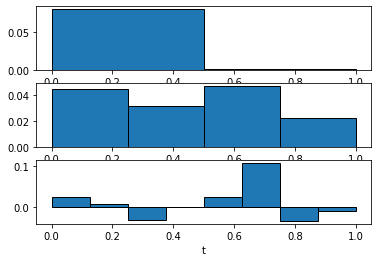

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[30, 45, 60]-0.1-Backprop-NormalInit-SEED-1.pkl


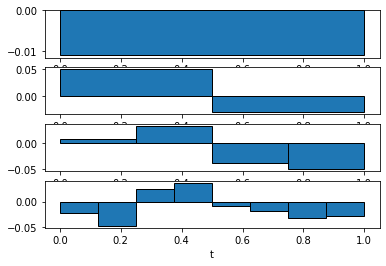

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 40, 60]-0.1-Backprop-NormalInit-SEED-1.pkl


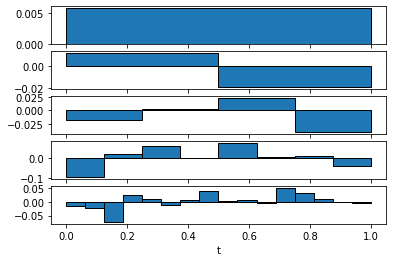

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[30, 40]-0.1-Backprop-NormalInit-SEED-1.pkl


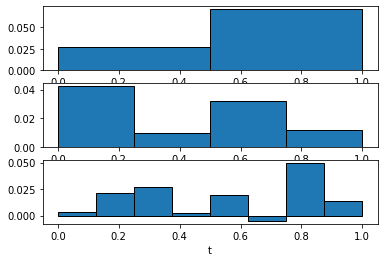

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30, 40, 50]-0.1-Backprop-NormalInit-SEED-1.pkl


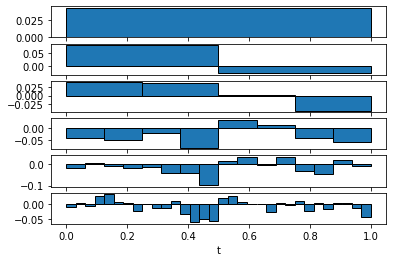

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[45, 60]-0.1-Backprop-NormalInit-SEED-1.pkl


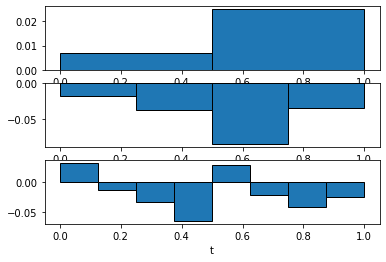

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[60, 120]-0.1-Backprop-NormalInit-SEED-1.pkl


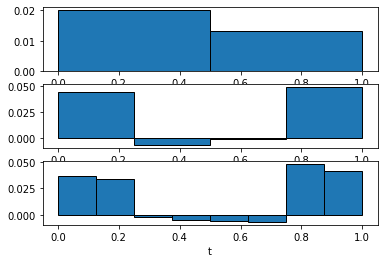

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[50, 100]-0.1-Backprop-NormalInit-SEED-1.pkl


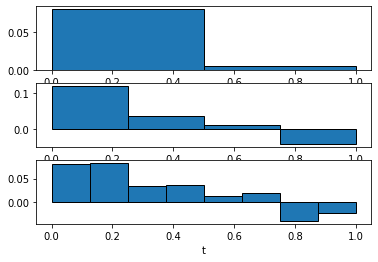

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 80]-0.1-Backprop-NormalInit-SEED-1.pkl


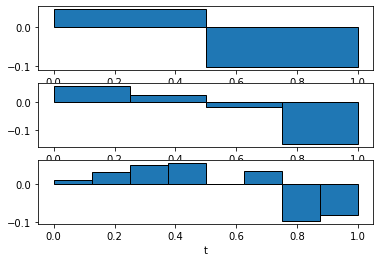

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[30, 60]-0.1-Backprop-NormalInit-SEED-1.pkl


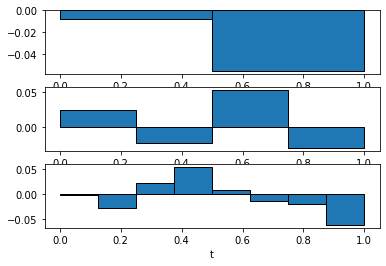

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 40, 60]-0.1-Backprop-NormalInit-SEED-1.pkl


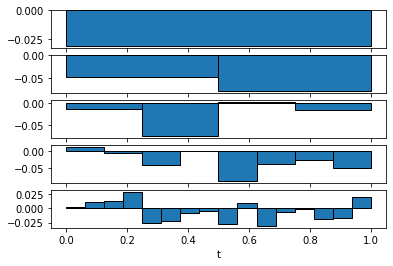

In [125]:
for name,result in results.items():
    i,j=0,0
    for a,b in [(2,2)]: #np.ndindex(result.model_list[0].net[2].net.L1.weight.shape[-2:]):
        print(name)
        plotting.plot_weights_over_time(
            result.model_list,
            lambda x : x.net[5].net.L1.weight[:,i,j,a,b].cpu(),
            lambda x : x.net[5].ts.cpu())


# Manifestation Invariance

In [90]:
sdb = SimDataDB("results/manifestation_study.sqlite")

In [91]:
refset,trainset,trainloader,testset,testloader = \
    datasets.get_dataset("CIFAR10",root='../data/')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [92]:
@sdb.Decorate(
    "fmnist",
    [("network","STRING"),("scheme","STRING"),("num_time","INT"),],
    [("train_acc","INT")])
@torch.no_grad()
def calc_acc_for_scheme_nt(name, scheme, nt):
    mod = results[name].model_list[-1]
    mod.eval()
    set_ode_config(mod, nt, scheme)
    return [refine_train.calculate_accuracy(mod, testloader)]

CREATE TABLE IF NOT EXISTS fmnist ( network STRING, scheme STRING, num_time INT, train_acc INT, timestamp VARCHAR(30), runtime FLOAT );


In [ ]:
test_sweep = defaultdict( lambda : {} )
with torch.no_grad():
    for name, result in results.items():
        accs_for_scheme = {}
        for scheme in ('euler', 'midpoint','rk4'):
            accs = []
            for nt in progress( range(1, 41, 1), f"{legend_name(name)}, {scheme}"):
                accs.append((nt, calc_acc_for_scheme_nt(name, scheme, nt)[0]))
            accs_for_scheme[scheme] = accs
        test_sweep[name].update(accs_for_scheme)


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 40/40 [00:00<00:00, 1705.16it/s]

-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 40/40 [00:00<00:00, 1719.75it/s]

-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 40/40 [00:00<00:00, 1697.84it/s]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 40/40 [00:00<00:00, 1723.13it/s]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 40/40 [00:00<00:00, 1704.08it/s]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 40/40 [00:00<00:00, 1648.93it/s]

-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backp

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 22, 0.5721, datetime.datetime(2020, 5, 22, 9, 3, 59, 370769), 16.552005767822266]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  57%|█████▊    | 23/40 [00:33<01:37,  5.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 23, 0.5863, datetime.datetime(2020, 5, 22, 9, 4, 15, 932095), 17.274996757507324]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 24/40 [00:51<02:30,  9.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 24, 0.573, datetime.datetime(2020, 5, 22, 9, 4, 33, 216597), 17.98939847946167]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  62%|██████▎   | 25/40 [01:10<03:02, 12.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 25, 0.5862, datetime.datetime(2020, 5, 22, 9, 4, 51, 215393), 18.705360651016235]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  65%|██████▌   | 26/40 [01:29<03:21, 14.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 26, 0.5737, datetime.datetime(2020, 5, 22, 9, 5, 9, 930231), 19.406773805618286]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  68%|██████▊   | 27/40 [01:50<03:29, 16.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 27, 0.5862, datetime.datetime(2020, 5, 22, 9, 5, 29, 346356), 20.148011684417725]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  70%|███████   | 28/40 [02:11<03:30, 17.56s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 28, 0.5741, datetime.datetime(2020, 5, 22, 9, 5, 49, 504218), 20.9655442237854]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  72%|███████▎  | 29/40 [02:32<03:27, 18.82s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 29, 0.5862, datetime.datetime(2020, 5, 22, 9, 6, 10, 479783), 21.75613760948181]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  75%|███████▌  | 30/40 [02:55<03:19, 19.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 30, 0.5747, datetime.datetime(2020, 5, 22, 9, 6, 32, 246091), 22.52969527244568]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  78%|███████▊  | 31/40 [03:19<03:09, 21.03s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 31, 0.5863, datetime.datetime(2020, 5, 22, 9, 6, 54, 785617), 23.56586742401123]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 32/40 [03:43<02:56, 22.02s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 32, 0.5757, datetime.datetime(2020, 5, 22, 9, 7, 18, 361312), 24.31610608100891]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  82%|████████▎ | 33/40 [04:08<02:40, 22.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 33, 0.5863, datetime.datetime(2020, 5, 22, 9, 7, 42, 686830), 25.006492376327515]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  85%|████████▌ | 34/40 [04:34<02:22, 23.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 34, 0.5762, datetime.datetime(2020, 5, 22, 9, 8, 7, 702465), 25.747456312179565]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  88%|████████▊ | 35/40 [05:00<02:02, 24.58s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 35, 0.5863, datetime.datetime(2020, 5, 22, 9, 8, 33, 459469), 26.45775055885315]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  90%|█████████ | 36/40 [05:27<01:41, 25.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 36, 0.577, datetime.datetime(2020, 5, 22, 9, 8, 59, 927080), 27.22468638420105]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  92%|█████████▎| 37/40 [05:55<01:18, 26.15s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 37, 0.5864, datetime.datetime(2020, 5, 22, 9, 9, 27, 163037), 27.94270920753479]



-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  95%|█████████▌| 38/40 [06:24<00:53, 26.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 38, 0.5777, datetime.datetime(2020, 5, 22, 9, 9, 55, 115293), 28.6799418926239]


This creates the plot for skipinit

{1: 0, 2: 1, 3: 2, 4: 3}
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFA

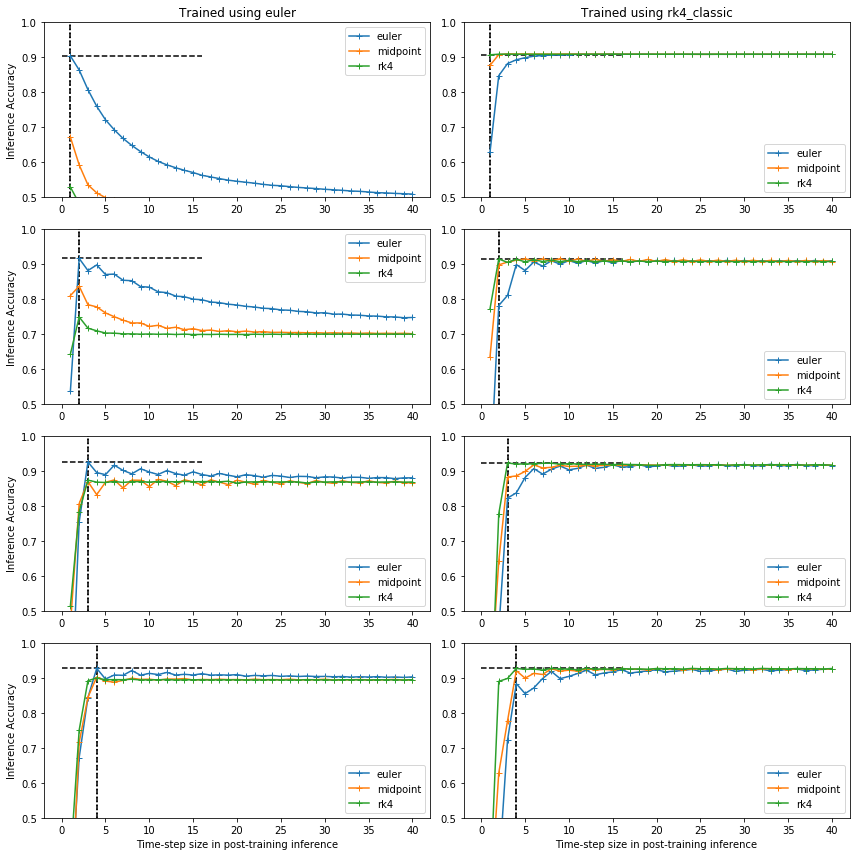

In [76]:
plt.figure(figsize=(12,12))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if args.use_skip_init: continue
    cols.append(args.final_time_d)
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if args.use_skip_init: continue
    print(name)
    col = cols[args.final_time_d]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme in args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,16.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.5,1.0)
    plt.legend()
    if col == max(cols.values()):
        plt.xlabel('Time-step size in post-training inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel("Inference Accuracy")
plt.tight_layout()
plt.show()

This creates the plot for all of the backprops

## SkipInit

{4: 0, 6: 1, 8: 2, 12: 3}
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-12-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
res

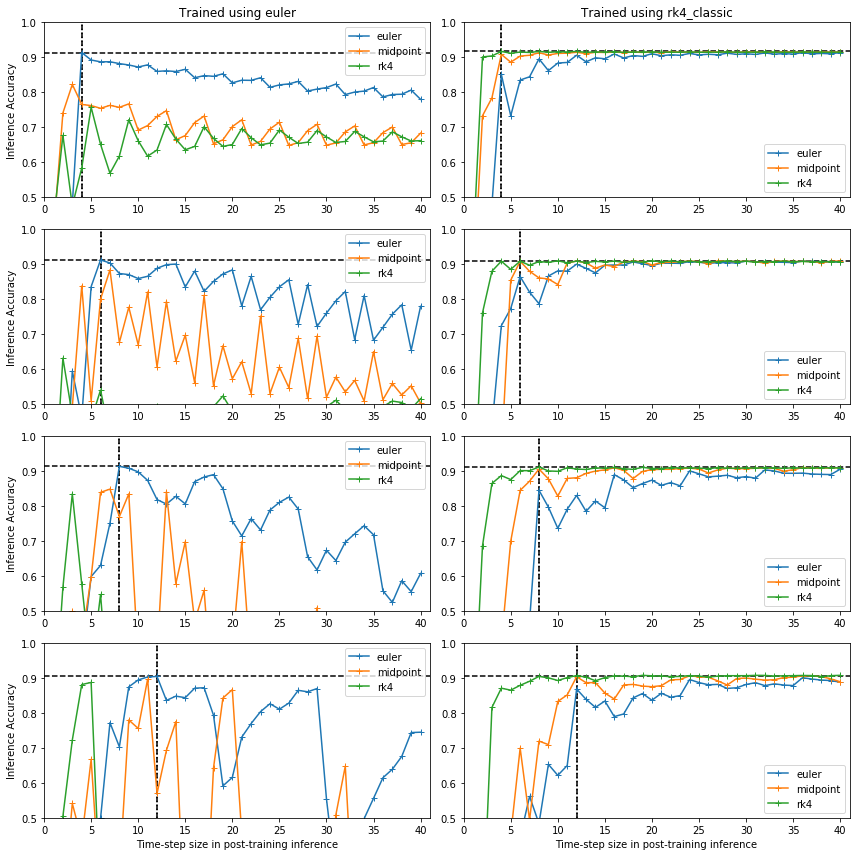

In [75]:
plt.figure(figsize=(12,12))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if not args.use_skip_init: continue
    cols.append(args.final_time_d)
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if not args.use_skip_init: continue
    print(name)
    col = cols[args.final_time_d]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme in args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,41.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.5,1.0)
    plt.xlim(0,41)
    plt.legend()
    if col == max(cols.values()):
        plt.xlabel('Time-step size in post-training inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel("Inference Accuracy")
plt.tight_layout()
plt.show()

## Refinement + BatchNorm

{(10, 20, 30): 0, (10, 20, 30, 40, 50): 1, (10, 20, 40, 60): 2, (20, 30, 40): 3, (30, 40): 4, (30, 45, 60): 5, (30, 60): 6, (40, 80): 7, (45, 60): 8, (50, 100): 9, (60, 120): 10}
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[20, 30, 40]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[30, 45, 60]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-[30, 40]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-[45, 60]-0.1-Ba

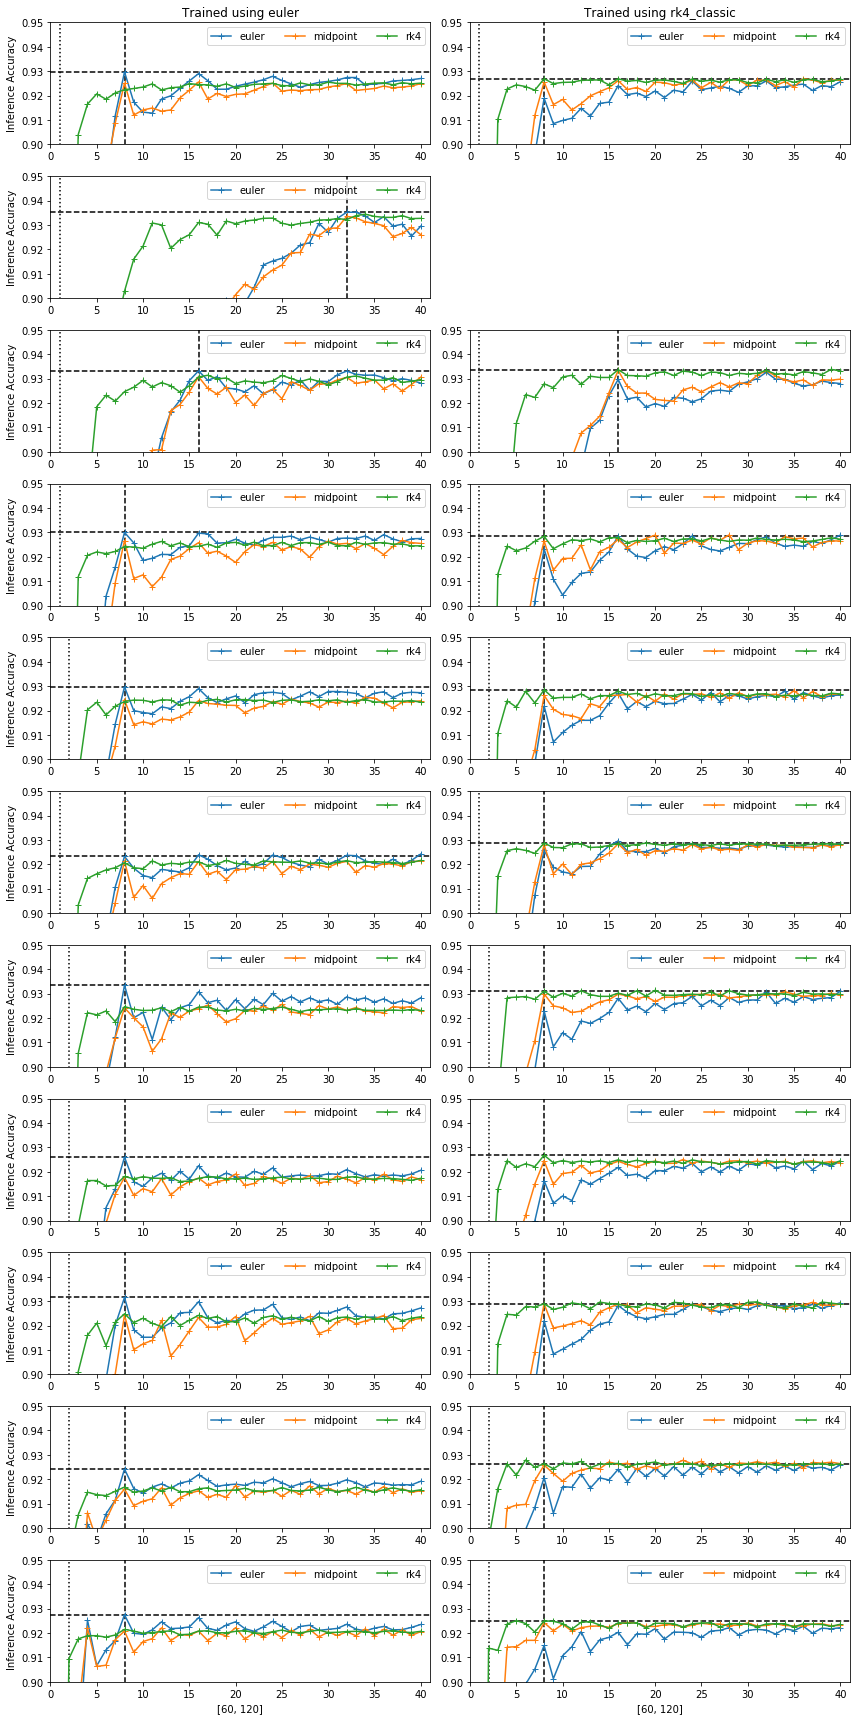

In [89]:
plt.figure(figsize=(12,24))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if args.use_skip_init: continue
    cols.append(tuple(args.refine))
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if args.use_skip_init: continue
    print(name)
    col = cols[tuple(args.refine)]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme in args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,41.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.9,0.95)
    plt.xlim(0,41)
    plt.legend(ncol=3)
    if col == max(cols.values()):
        plt.xlabel(f'{args.refine}')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel("Inference Accuracy")
plt.tight_layout()
plt.show()

## Refinement + SkipInit

In [82]:
plt.figure(figsize=(12,12))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if not args.use_skip_init: continue
    cols.append(args.final_time_d)
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if not args.use_skip_init: continue
    print(name)
    col = cols[args.final_time_d]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme in args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,41.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.5,1.0)
    plt.xlim(0,41)
    plt.legend()
    if col == max(cols.values()):
        plt.xlabel('Time-step size in post-training inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel("Inference Accuracy")
plt.tight_layout()
plt.show()

{}


<Figure size 864x864 with 0 Axes>